## Clonando o repositório com os dados do problema

In [1]:
!rm -r IEC.PUC.Modelo.Notif.Dengue
!git clone https://github.com/cgalmeida/IEC.PUC.Modelo.Notif.Dengue.git

rm: cannot remove 'IEC.PUC.Modelo.Notif.Dengue': No such file or directory
Cloning into 'IEC.PUC.Modelo.Notif.Dengue'...
remote: Enumerating objects: 835, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 835 (delta 7), reused 48 (delta 3), pack-reused 768
Receiving objects: 100% (835/835), 101.99 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (565/565), done.


## Instalando o otimizador

In [2]:
! pip install adabelief-tf --quiet

## Fazendo os imports das libs necessárias

In [3]:
import os
from io import StringIO
import codecs
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from adabelief_tf import AdaBeliefOptimizer
import random as python_random

## Especificando o caminho para os dados

In [4]:
path_data = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados')
path_data

'IEC.PUC.Modelo.Notif.Dengue/dados'

In [5]:
path_base = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'metadados')
path_base

'IEC.PUC.Modelo.Notif.Dengue/dados/metadados'

## Lendo os dados e armazenando em uma lista

In [6]:
def only_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

def break_test(s):
    return 'SINAN NET' not in s.upper()

def read_file(file_path, line_pos):
    fp = codecs.open(file_path, 'r', encoding='latin-1')
    txt_lines = fp.readlines()[line_pos:]
    md = [s for s in txt_lines]
    data_lines = list(itertools.takewhile(break_test, txt_lines))
    fp.close()
    return data_lines

def to_dataframe(lst):
    return pd.read_csv(StringIO(''.join(lst)), sep=';', encoding = "latin-1")

def create_col_year(df, filename_var):
    df = df.replace('-', '0')
    df['Ano'] = filename_var[-8:-4]
    return df.drop(columns=['Total'])

def read_folder(path_data, filename_var):
    files = list(only_files(path_data))
    files.sort()    
    return [create_col_year(to_dataframe(read_file(os.path.join(path_data, file_name), 3)), file_name) for file_name in files if filename_var in file_name]

def read_base(filename_var):
    file_path = os.path.join(path_base, filename_var) + '.csv'
    return pd.read_csv(file_path, sep=';', encoding = "ISO-8859-1")

def merge_base(df_data, df_base):
    df_data.columns.values[0] = 'Descricao'
    return pd.merge(df_data, df_base, on='Descricao', how='inner')

def transpose_data(df):
    # df.set_index(['descricao','Ano','codigo']).stack().reset_index()
    return df.melt(id_vars=['Descricao','Ano','Codigo']).rename(columns={'variable':'Mes', 'value': 'Casos'})

def format_res(df):
    df_mes = read_base('mes_abr').rename(columns={'Codigo': 'Codigo_Mes', 'Descricao': 'Mes'})
    df_mes = pd.merge(df, df_mes, on=['Mes'], how='inner')
    df_mes['Periodo'] = df_mes.apply(lambda x: x.Ano + '.' + str(x.Codigo_Mes).zfill(2), axis=1)
    return df_mes

def type_col(df):
    df['Descricao'] = df['Descricao'].astype('str')
    df['Ano'] = df['Ano'].astype('int64')
    df['Mes'] = df['Mes'].astype('str')
    df['Casos'] = df['Casos'].astype('int64')
    df['Periodo'] = df['Periodo'].astype('str')
    return df

def prepare_data(path_data, filename_var):
    df_base = read_base(filename_var)
    res = [merge_base(i, df_base) for i in read_folder(path_data, filename_var)]
    res = [format_res(transpose_data(df)) for df in res]    
    res = pd.concat(res[:], axis=0).reset_index(drop=True)
    res = type_col(res)
    res = res.groupby(['Ano', 'Codigo', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index()
    return pd.merge(res, df_base, on=['Codigo'], how='inner')

def totalizar(df):
    return df.groupby(['Ano', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index().drop(columns=['Codigo'])

In [7]:
%%time
filename_var = 'macrorregiao'
data_list = prepare_data(path_data, filename_var)
data_list = totalizar(data_list)
data_list.head()

CPU times: user 307 ms, sys: 5.16 ms, total: 312 ms
Wall time: 340 ms


,Ano,Codigo_Mes,Periodo,Casos
0,2007,1,2007.01,1625
1,2007,2,2007.02,3189
2,2007,3,2007.03,7899
3,2007,4,2007.04,8351
4,2007,5,2007.05,4547


In [254]:
data = data_list['Casos'].values.tolist()

## Dando uma olhada no dataset

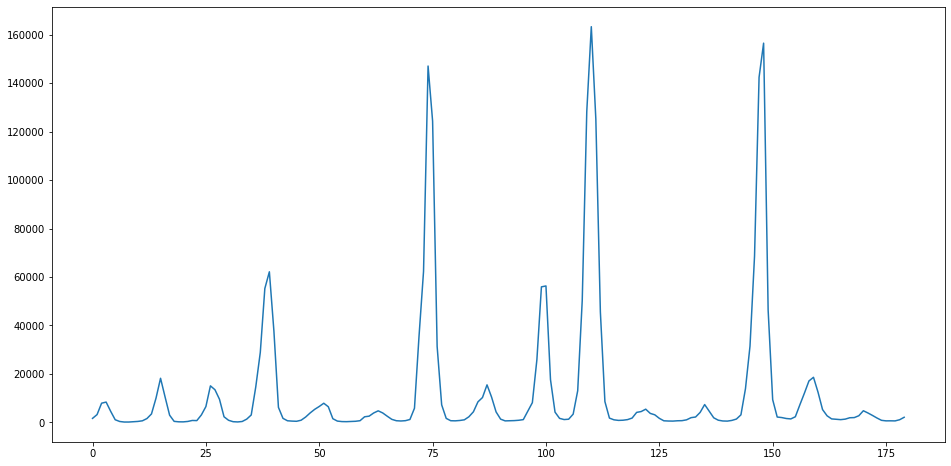

In [9]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(data)
plt.show()

## Processando o dado

In [255]:
dataframe =  data_list['Casos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform([[i] for i in dataset])

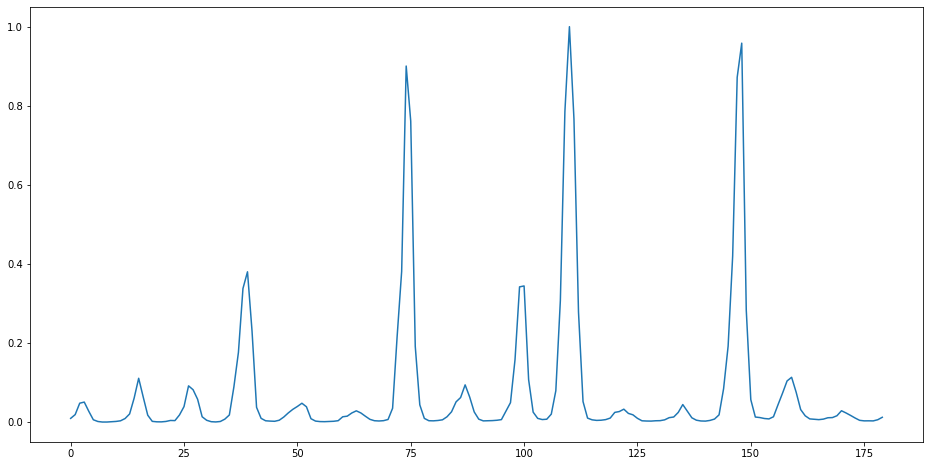

In [11]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(dataset)
plt.show()

## "Aumentando o dado" 

A quantidade de observações da série é pequena, em torno de 100.

Necessita-se aumentar artificialmente a série para melhor avaliar e treinar o modelo.

In [12]:
! pip install tsaug --quiet

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35c60dbed0>)

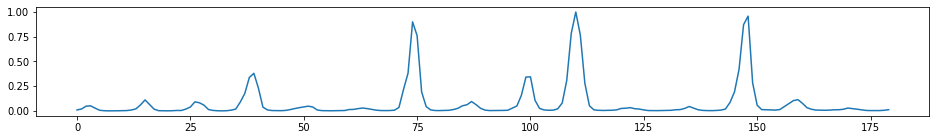

In [13]:
from tsaug.visualization import plot as plt_au

use_aug = False
d_test = dataset.reshape(1, 180).flat[0:180]
plt_au(d_test)

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35c5a30a10>)

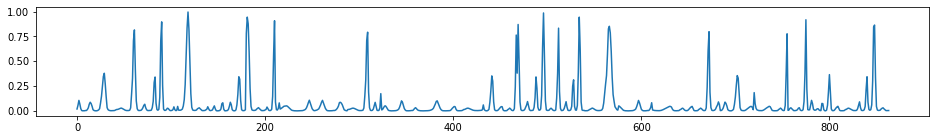

In [14]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

repeat = 24
d_test = dataset.reshape(1, 180).flat[0:180]
my_augmenter = (TimeWarp() * repeat
                + Crop(size=36)
)
new_data = my_augmenter.augment(d_test)
len_data = len(new_data[0]) * repeat
d_test = new_data.reshape(1, len_data).flat[0:len_data]
plt_au(np.array(d_test))

In [15]:
if use_aug:
  dataset = np.array([[i] for i in d_test])
  dataset.shape

## Separando o dado em treino e teste

In [16]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

120 60


In [59]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_convergence(hist: tf.keras.callbacks.History, 
                     metric_name:str) -> None:
  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')
  
  ax = plt.axes()
  ax.set_facecolor("darkgrey")
  
  plt.xlabel('Epoch', fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylabel(metric_name.title(), fontsize=14)
  plt.yticks(fontsize=14)

  plt.plot(range(1, len(hist.history[metric_name.lower()]) + 1), 
           hist.history[metric_name.lower()], marker='o', linewidth=3, 
           markersize=12)
  plt.plot(range(1, len(hist.history[f'val_{metric_name.lower()}']) + 1), 
           hist.history[f'val_{metric_name.lower()}'], marker='X', linewidth=3, 
           markersize=12)
  plt.legend([metric_name.title(), f'Validation {metric_name.title()}'], 
             fontsize=14)
  plt.show()

def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

In [18]:
learning_rate = 1e-3
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

## Preparando o dado

In [19]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Criando, compilando e treinando o modelo

In [20]:
%%time
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
#model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))


CPU times: user 682 ms, sys: 44.6 ms, total: 727 ms
Wall time: 900 ms


In [21]:
model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

In [22]:
hist = model.fit(trainX,
                 trainY,
                 epochs=400,
                 batch_size=128,
                 validation_split=0.2)

Epoch 1/400
1/1 [==============================] - 7s 7s/step - loss: 0.0243 - val_loss: 0.1230
Epoch 2/400
1/1 [==============================] - 0s 63ms/step - loss: 0.0243 - val_loss: 0.1229
Epoch 3/400
1/1 [==============================] - 0s 45ms/step - loss: 0.0242 - val_loss: 0.1229
Epoch 4/400
1/1 [==============================] - 0s 68ms/step - loss: 0.0242 - val_loss: 0.1228
Epoch 5/400
1/1 [==============================] - 0s 58ms/step - loss: 0.0242 - val_loss: 0.1227
Epoch 6/400
1/1 [==============================] - 0s 41ms/step - loss: 0.0242 - val_loss: 0.1227
Epoch 7/400
1/1 [==============================] - 0s 102ms/step - loss: 0.0242 - val_loss: 0.1226
Epoch 8/400
1/1 [==============================] - 0s 70ms/step - loss: 0.0241 - val_loss: 0.1225
Epoch 9/400
1/1 [==============================] - 0s 69ms/step - loss: 0.0241 - val_loss: 0.1224
Epoch 10/400
1/1 [==============================] - 0s 43ms/step - loss: 0.0241 - val_loss: 0.1222
Epoch 11/400
1/1 [==

## Plotando a convergência

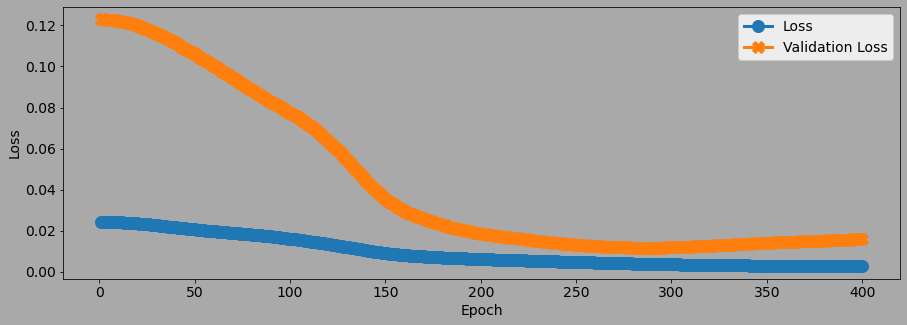

In [23]:
plot_convergence(hist, 'loss')

## Fazendo as predições para os dados

In [24]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 5ms/step
Train Score: 11851.69 RMSE
Test Score: 9280.86 RMSE


## Vendo a série prevista pela rede

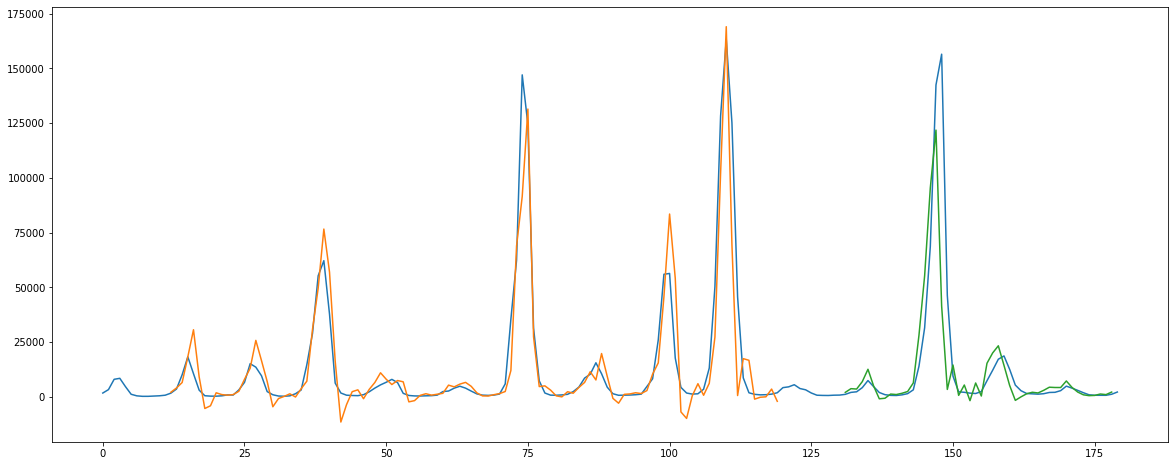

In [25]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Fazendo a previsão para um período futuro (em meses)

In [26]:
def create_forecast(model_fc, init_data, period=12):
    new_data = []
    new_test = list(init_data)
    for i in range(period):
        test_item = np.array([[new_test]])
        p_val = model_fc.predict(test_item)
        new_test = new_test[1:look_back] + [p_val[0][0]]
        new_data.append(new_test)
    return new_data

lastX = testX[testX.shape[0]-1][0]
predX = create_forecast(model, lastX)
new_testX = np.array(predX)
new_testX = np.reshape(new_testX, (new_testX.shape[0], 1, new_testX.shape[1]))
new_testX = np.append(testX, new_testX, axis=0)

repeat = new_testX.shape[0] - testX.shape[0]
new_dataset = np.append(dataset, [[i] for i in np.repeat(0, repeat)], axis=0)

1/1 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 6ms/step
108
25
133


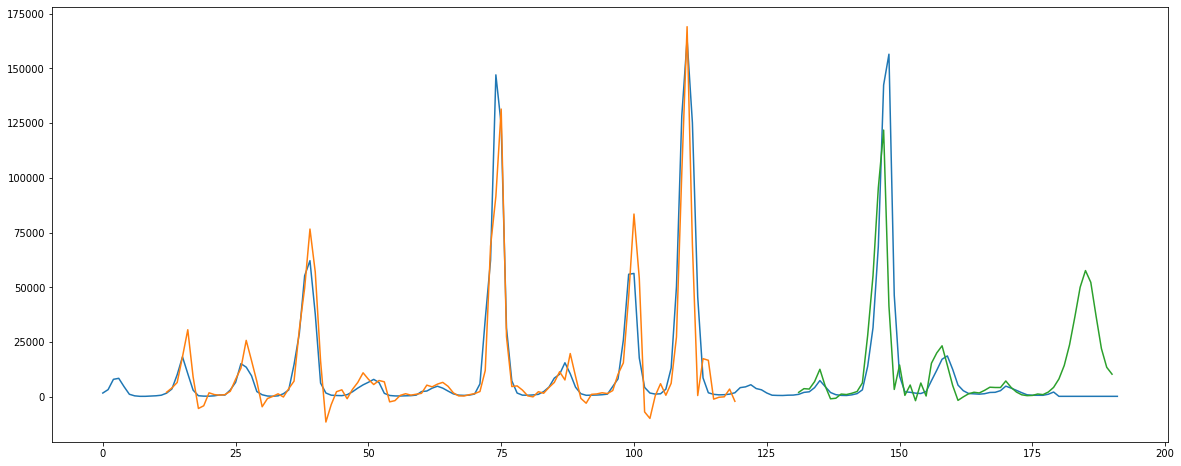

In [27]:
trainPredict = model.predict(trainX)
testPredict = model.predict(new_testX)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:, :] = np.nan
print(len(trainPredict))
print((look_back*2)+1)
print(len(trainPredict)+(look_back*2)+1)
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(new_dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(new_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Modelo autokeras

In [28]:
! pip install autokeras --quiet

     |████████████████████████████████| 162 kB 27.4 MB/s 
     |████████████████████████████████| 135 kB 60.8 MB/s 
     |████████████████████████████████| 1.6 MB 35.0 MB/s 


In [29]:
dataframe =  data_list['Casos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform([[i] for i in dataset])

In [30]:
train_size = int(len(dataset) * 0.67)
validation_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

120 60


In [31]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#trainX = np.reshape(trainX, (trainX.shape[0], 1))
#testX = np.reshape(testX, (testX.shape[0], 1))

In [32]:
import autokeras as ak

predict_from = 1
predict_until = 10
model_clf = ak.TimeseriesForecaster(
    lookback=12,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss"
)
# Train the TimeSeriesForecaster with train data
model_clf.fit(
    x=trainX,
    y=trainY,
    validation_data=(testX, testY),
    batch_size=32,
    epochs=100
)

# Evaluate the best model with testing data.
print(model_clf.evaluate(testX, testY))

Trial 1 Complete [00h 00m 29s]
val_loss: 0.04096880555152893

Best val_loss So Far: 0.04096880555152893
Total elapsed time: 00h 00m 29s
Epoch 1/100
4/4 [==============================] - 8s 627ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 2/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 4/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 5/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 6/100
4/4 [==============================] - 0s 30ms/step

2/2 [==============================] - 2s 27ms/step - loss: 0.0334 - mean_squared_error: 0.0334
[0.033400896936655045, 0.033400896936655045]


In [33]:
best_model = model_clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 12, 2)            24        
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 2)                32        
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 regression_head_1 (Dense)   (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0

In [34]:
best_model.fit(
    x=trainX,
    y=trainY,
    validation_data=(testX, testY),
    batch_size=32,
    epochs=100
)

Epoch 1/100


1/4 [======>.......................] - ETA: 28s - loss: 0.0318 - mean_squared_error: 0.0318

4/4 [==============================] - 11s 525ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 7/100
4/4 [==============================] -

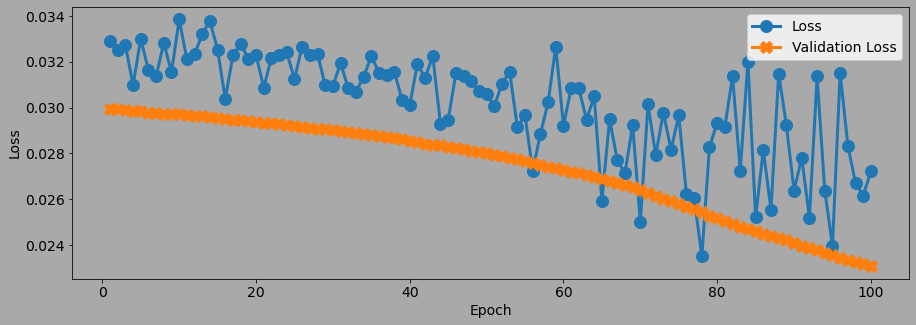

In [35]:
plot_convergence(best_model.history, "loss")

In [36]:
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 8ms/step
Train Score: 25708.69 RMSE
Test Score: 24791.62 RMSE


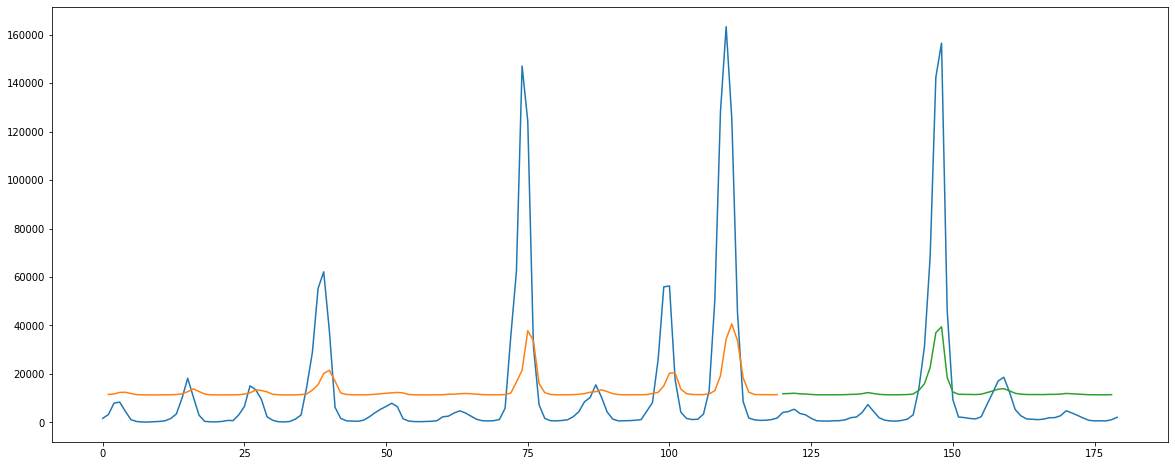

In [37]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Facebook Prophet

In [43]:
! pip install sktime --quiet

In [39]:
from sktime.forecasting.fbprophet import Prophet

# Prophet requires to have data with a pandas.DatetimeIndex

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = Prophet(  
    seasonality_mode='additive',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality='auto')

forecaster.fit(y)
period = list(range(1,13))
y_pred = forecaster.predict(fh=period)  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja43uvv7/lextmu9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja43uvv7/kzz42h_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36089', 'data', 'file=/tmp/tmpja43uvv7/lextmu9h.json', 'init=/tmp/tmpja43uvv7/kzz42h_q.json', 'output', 'file=/tmp/tmpja43uvv7/prophet_model1xwn85qv/prophet_model-20221018171053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


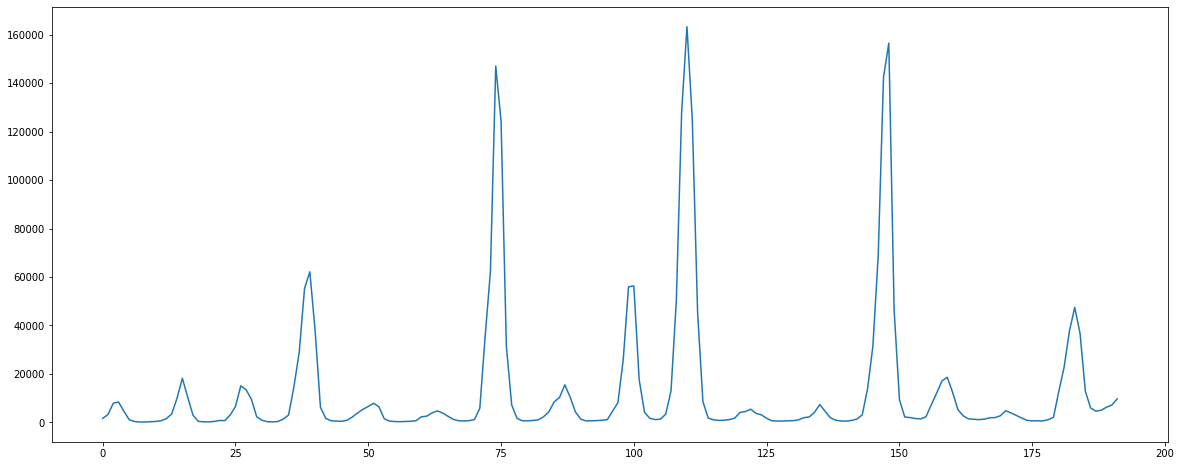

In [55]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## TBAT - Modelo estatístico

In [44]:
! pip install tbats --quiet

     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |████████████████████████████████| 9.8 MB 52.0 MB/s 


In [231]:
from sktime.forecasting.tbats import TBATS

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = TBATS(  
    use_box_cox=False,
    use_trend=True,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)

forecaster.fit(y)  

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)

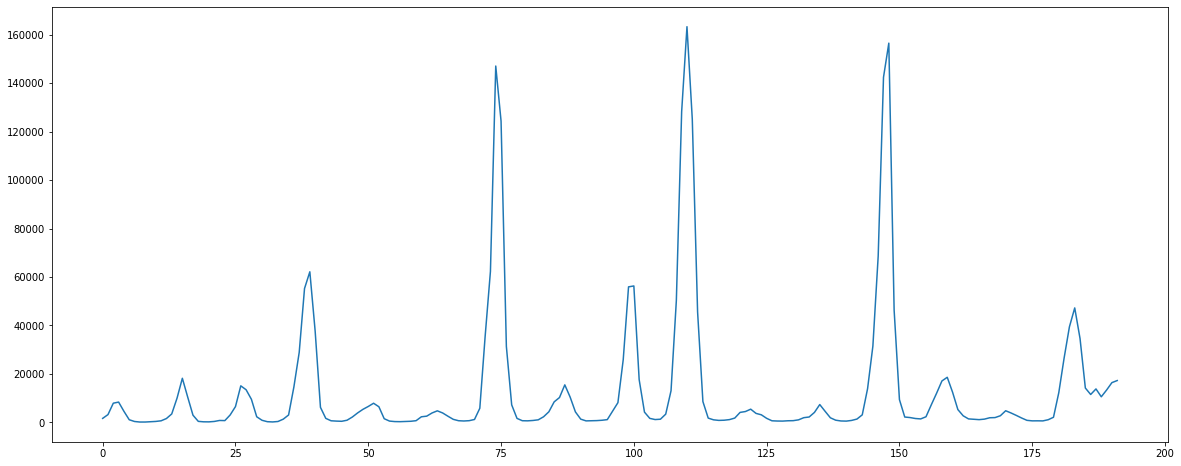

In [232]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## SARIMAX - Modelo estatístico

In [234]:
from sktime.forecasting.sarimax import SARIMAX

forecaster = SARIMAX(order=(1, 0, 0), trend="t", seasonal_order=(1, 0, 0, 6))

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster.fit(y)

p_idx = pd.date_range(start='2022-01-01', end='2022-12-31', freq='M')

y_pred = forecaster.predict(fh=p_idx)


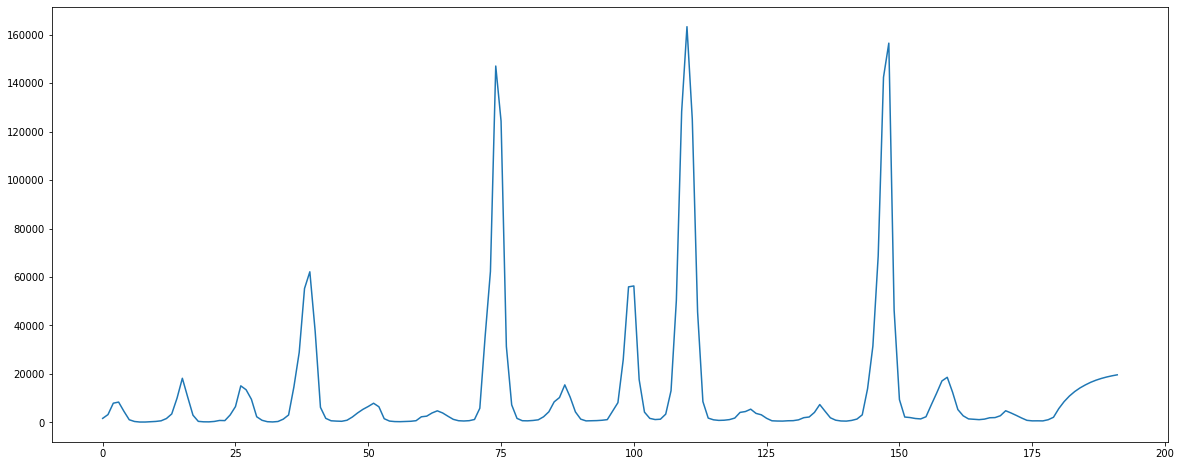

In [236]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## Exponential Smoothing

In [283]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = ExponentialSmoothing(trend='add', seasonal='additive', sp=12)
forecaster.fit(y)

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)

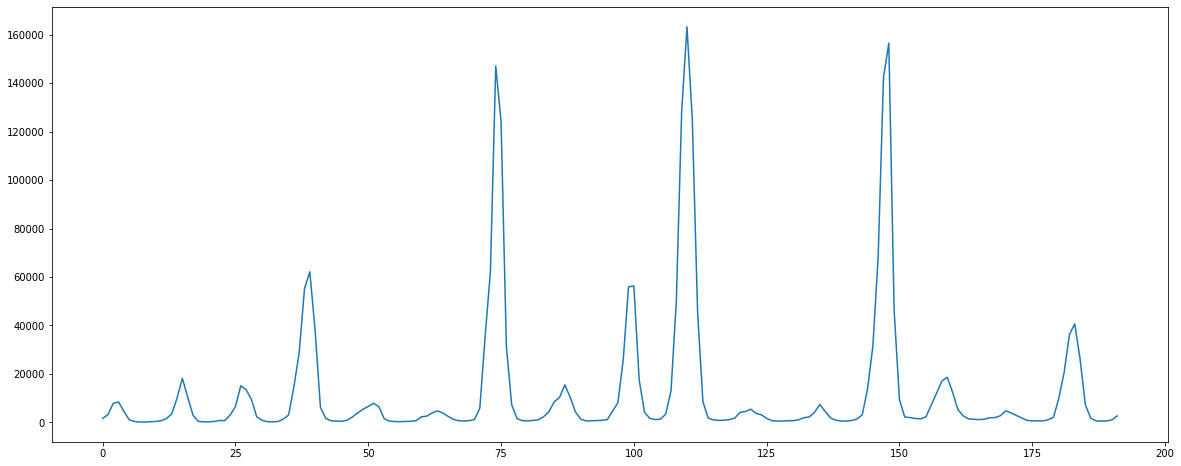

In [284]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## Auto ETS

In [285]:
from sktime.forecasting.ets import AutoETS

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
forecaster.fit(y)

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)


/usr/local/lib/python3.7/dist-packages/sktime/forecasting/ets.py:252: UserWarning: Warning: time series is not strictly positive, multiplicative components are ommitted
  "Warning: time series is not strictly positive, "


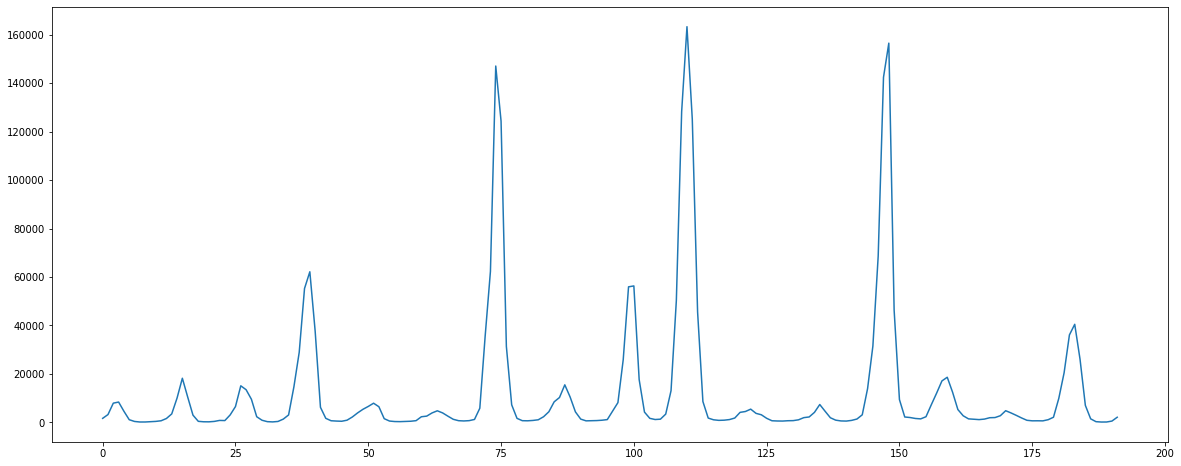

In [286]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## Rede Neural - Teste com dataset organizado de modo sazonal

In [158]:
def create_season_dataset(dataset, look_back=1, n_season=12):
		if len(dataset) % n_season != 0:
				raise Exception("Error: dataset lenght must be divided by 'n_season' parameter!") 
		dataX, dataY = [], []
		for i in range(len(dataset) - (n_season * look_back)):
				X = []
				for j in range(look_back):
						X.append(dataset[i+(j*n_season)])
				y = dataset[i+(n_season * look_back)]
				dataX.append(X)
				dataY.append(y)
		return np.array(dataX), np.array(dataY)

In [201]:
learning_rate = 1e-3
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

In [186]:
val_seasons = 12
n_sets = len(dataset) / val_seasons
train_size = int(n_sets * 0.67) * val_seasons
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

120 60


In [187]:
look_back = 4
trainX, trainY = create_season_dataset(train, look_back)
testX, testY = create_season_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(72, 1, 4)
(12, 1, 4)


In [225]:
%%time
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))

model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

hist = model.fit(trainX,
                 trainY,
                 epochs=50,
                 batch_size=64,
                 validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.0339 - val_loss: 0.1579
Epoch 2/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0334 - val_loss: 0.1561
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0329 - val_loss: 0.1540
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0322 - val_loss: 0.1516
Epoch 5/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0315 - val_loss: 0.1489
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0308 - val_loss: 0.1461
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0301 - val_loss: 0.1431
Epoch 8/50
1/1 [==============================] - 0s 35ms/step - loss: 0.0294 - val_loss: 0.1399
Epoch 9/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0289 - val_loss: 0.1368
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0284 - val_loss: 0.1336
Epoch 11/50
1/1 [============

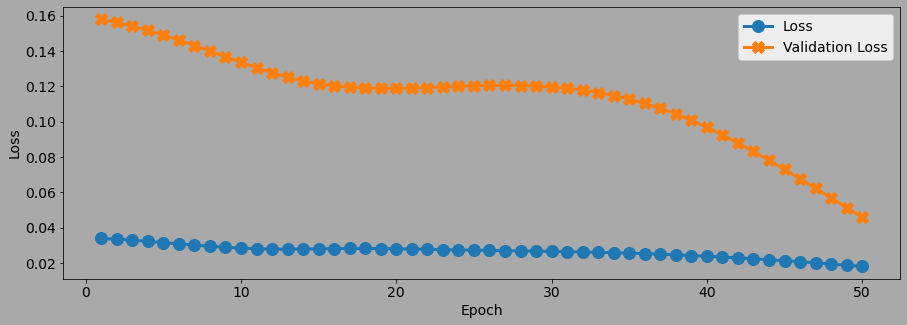

In [226]:
plot_convergence(hist, 'loss')

5/5 [==============================] - 1s 3ms/step


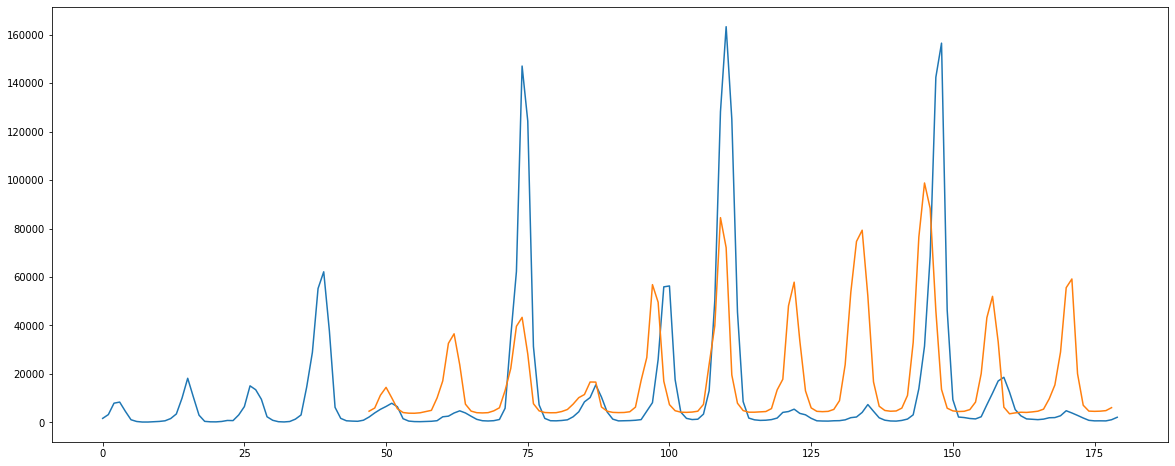

In [227]:
testX, testY = create_season_dataset(dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict = model.predict(testX)

testPredict = scaler.inverse_transform(testPredict)

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[(look_back*val_seasons)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.show()

## Valores futuros

5/5 [==============================] - 0s 3ms/step


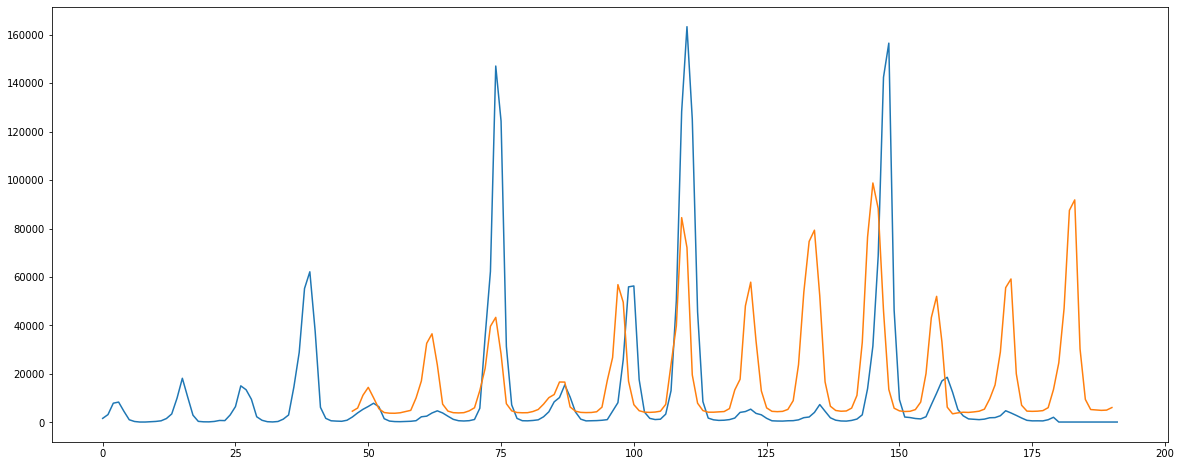

In [228]:
n_period = 1
fut_val = np.array([[i] for i in np.repeat(0, val_seasons * n_period)])
new_dataset = np.concatenate((dataset, fut_val), axis=0)
testX, testY = create_season_dataset(new_dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict = model.predict(testX)

testPredict = scaler.inverse_transform(testPredict)

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[(look_back*val_seasons)-1:len(new_dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(new_dataset))
plt.plot(testPredictPlot)
plt.show()